# Final position in variable interval


## Dependencies


The dependencies used are as follows


In [1]:
from sklearn.metrics import make_scorer

from xgboost import XGBClassifier, XGBRegressor, XGBRanker

import sys

sys.path.append("..")

from utils.visualization import model_tuning
from utils.custom_cvs import VariableTimeSeriesSplit
from utils.custom_scorers import (
    balanced_accuracy_1interval_score,
    balanced_accuracy_1interval_ranker,
)

import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import warnings

warnings.simplefilter("ignore")

## Initialization


First we will do the tuning of the model that predicts the final position of each driver at a ±1 interval.


In [2]:
df = pd.read_csv("../assets/data/processed/other_models.csv")

mid_rc = df.groupby("raceYear")["raceRound"].max().to_numpy() // 2
get_half = lambda x: f'{x["raceYear"]}{x["raceRound"] <= mid_rc[x["raceYear"] - 2006]}'
instances_per_half = df.apply(get_half, axis=1).value_counts(sort=False).to_numpy()

n_splits = len(instances_per_half) - 10
max_train_size = [instances_per_half[i : 10 + i].sum() for i in range(n_splits)]
test_size = instances_per_half[10:].tolist()
tscv = VariableTimeSeriesSplit(
    n_splits=n_splits, max_train_size=max_train_size, test_size=test_size
)

X = pd.read_csv("../assets/data/processed/other_models_X.csv")
y = df["positionFinal"]

## XGBClassifier


XGBClassifier: 0.358 with {'objective': 'multi:softmax', 'learning_rate':
	0.16194312071875708, 'n_estimators': 445, 'max_depth': 14, 'min_child_weight': 1,
	'gamma': 0.6785623145546271, 'subsample': 0.8474851222805517, 'colsample_bytree':
	0.717346395143139, 'reg_alpha': 4, 'reg_lambda': 43}


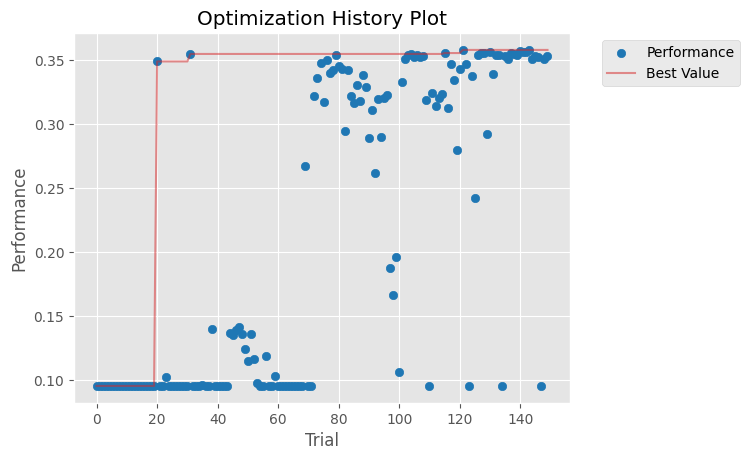

In [3]:
X_selected = X[
    [
        "carNumber",
        "positionGrid",
        "driverRef",
        "driverNationality",
        "constructorRef",
        "constructorNationality",
        "raceYear",
        "raceRound",
        "grandPrix",
        "raceTime",
        "circuitRef",
        "circuitLat",
        "circuitLng",
        "driverWins",
        "constructorWins",
        "q2",
        "driverAgeToday",
        "qid",
    ]
]
params = [
    ("categorical", ("objective", ["multi:softmax"])),
    ("float", ("learning_rate", 0.01, 0.2)),
    ("int", ("n_estimators", 20, 500)),
    ("int", ("max_depth", 1, 20)),
    ("int", ("min_child_weight", 1, 500)),
    ("float", ("gamma", 0, 0.9)),
    ("float", ("subsample", 0.5, 0.9)),
    ("float", ("colsample_bytree", 0.5, 0.9)),
    ("int", ("reg_alpha", 0, 101)),
    ("int", ("reg_lambda", 0, 101)),
]
model = XGBClassifier
scoring = make_scorer(balanced_accuracy_1interval_score)
model_tuning(params, model, X_selected, y - 1, tscv, scoring)

## XGBRegressor


XGBRegressor: 0.283 with {'objective': 'reg:linear', 'learning_rate':
	0.17948779360609146, 'n_estimators': 271, 'max_depth': 18, 'min_child_weight': 151,
	'gamma': 0.16803129043481835, 'subsample': 0.8766649870053588, 'colsample_bytree':
	0.5629210209427316, 'reg_alpha': 26, 'reg_lambda': 40}


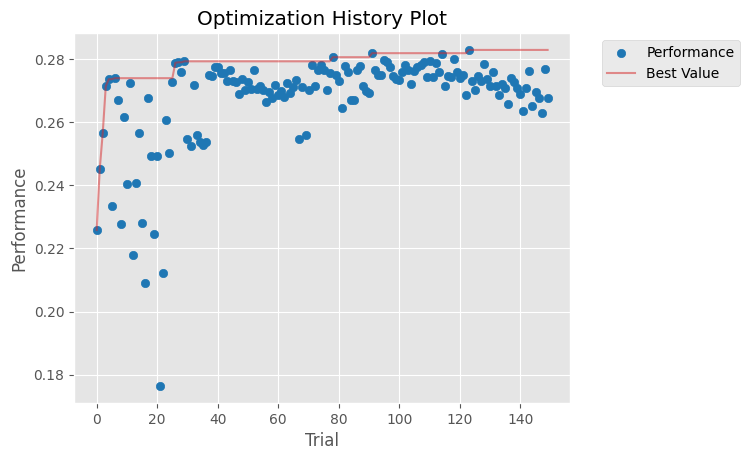

In [4]:
X_selected = X[
    [
        "carNumber",
        "positionGrid",
        "driverRef",
        "driverNumber",
        "driverNationality",
        "constructorRef",
        "constructorNationality",
        "raceTime",
        "circuitLocation",
        "circuitLat",
        "circuitLng",
        "circuitAlt",
        "constructorWins",
        "q3",
    ]
]
params = [
    ("categorical", ("objective", ["reg:linear"])),
    ("float", ("learning_rate", 0.01, 0.2)),
    ("int", ("n_estimators", 20, 500)),
    ("int", ("max_depth", 1, 20)),
    ("int", ("min_child_weight", 1, 500)),
    ("float", ("gamma", 0, 0.9)),
    ("float", ("subsample", 0.5, 0.9)),
    ("float", ("colsample_bytree", 0.5, 0.9)),
    ("int", ("reg_alpha", 0, 101)),
    ("int", ("reg_lambda", 0, 101)),
]
model = XGBRegressor
scoring = make_scorer(balanced_accuracy_1interval_score)
model_tuning(params, model, X_selected, y - 1, tscv, scoring)

## XGBRanker


XGBRanker: 0.348 with {'objective': 'rank:pairwise', 'learning_rate':
	0.013823969456976181, 'n_estimators': 282, 'max_depth': 19, 'min_child_weight': 23,
	'gamma': 0.3091756737651956, 'subsample': 0.7391411932524742, 'colsample_bytree':
	0.8966926377142095, 'reg_alpha': 6, 'reg_lambda': 3}


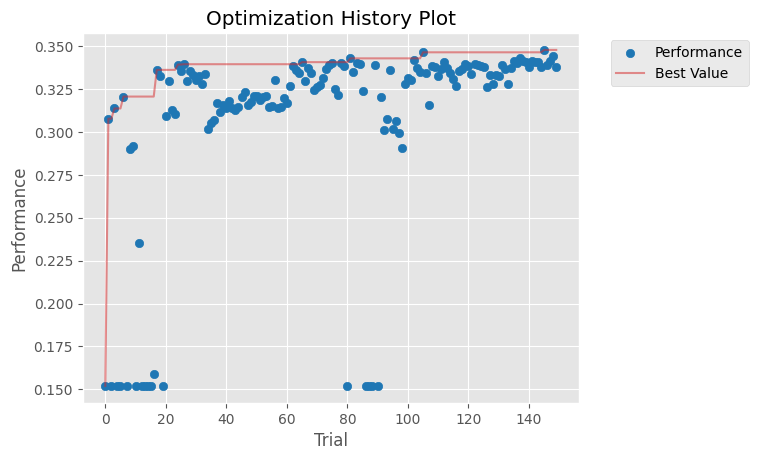

In [5]:
X_selected = X[
    [
        "carNumber",
        "positionGrid",
        "driverNationality",
        "constructorRef",
        "raceRound",
        "circuitRef",
        "circuitLng",
        "constructorWins",
        "q1",
        "q2",
        "driverAgeToday",
        "qid",
    ]
]
params = [
    ("categorical", ("objective", ["rank:pairwise"])),
    ("float", ("learning_rate", 0.01, 0.2)),
    ("int", ("n_estimators", 20, 500)),
    ("int", ("max_depth", 1, 20)),
    ("int", ("min_child_weight", 1, 500)),
    ("float", ("gamma", 0, 0.9)),
    ("float", ("subsample", 0.5, 0.9)),
    ("float", ("colsample_bytree", 0.5, 0.9)),
    ("int", ("reg_alpha", 0, 101)),
    ("int", ("reg_lambda", 0, 101)),
]
model = XGBRanker
scoring = balanced_accuracy_1interval_ranker
model_tuning(params, model, X_selected, y, tscv, scoring)

## Results


Therefore, the tuning for each algorithm are as follows

- XGBClassifier: 0.358 with {'objective': 'multi:softmax', 'learning_rate': 0.16194312071875708, 'n_estimators': 445, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.6785623145546271, 'subsample': 0.8474851222805517, 'colsample_bytree': 0.717346395143139, 'reg_alpha': 4, 'reg_lambda': 43}
- XGBRegressor: 0.283 with {'objective': 'reg:linear', 'learning_rate': 0.17948779360609146, 'n_estimators': 271, 'max_depth': 18, 'min_child_weight': 151, 'gamma': 0.16803129043481835, 'subsample': 0.8766649870053588, 'colsample_bytree': 0.5629210209427316, 'reg_alpha': 26, 'reg_lambda': 40}
- XGBRanker: 0.348 with {'objective': 'rank:pairwise', 'learning_rate': 0.013823969456976181, 'n_estimators': 282, 'max_depth': 19, 'min_child_weight': 23, 'gamma': 0.3091756737651956, 'subsample': 0.7391411932524742, 'colsample_bytree': 0.8966926377142095, 'reg_alpha': 6, 'reg_lambda': 3}
